In [1]:
import arviz as az
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [3]:
# Generate some data
np.random.seed(42)
n_inliers = 100
n_outliers = 10

In [4]:
# Inliers follow a normal distribution
mu_inlier, sigma_inlier = 0, 1
inliers = np.random.normal(mu_inlier, sigma_inlier, size=n_inliers)

In [5]:
# Outliers follow a different normal distribution
mu_outlier, sigma_outlier = 5, 1
outliers = np.random.normal(mu_outlier, sigma_outlier, size=n_outliers)

In [6]:
# Combine inliers and outliers
data = np.concatenate([inliers, outliers])

In [7]:
# Split data into training and test sets
train_size = int(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]

In [8]:
# Train the model on the training data
with pm.Model() as model:
    # Priors for mixture components (weights)
    pi = pm.Beta('pi', alpha=1, beta=1)  # Mixture proportion
    
    # Priors for inlier Gaussian
    mu_in = pm.Normal('mu_in', mu=0, sigma=10)
    sigma_in = pm.HalfNormal('sigma_in', sigma=10)
    
    # Priors for outlier Gaussian
    mu_out = pm.Normal('mu_out', mu=5, sigma=10)
    sigma_out = pm.HalfNormal('sigma_out', sigma=10)
    
    # Likelihood of data given mixture components
    inlier_dist = pm.Normal.dist(mu=mu_in, sigma=sigma_in)
    outlier_dist = pm.Normal.dist(mu=mu_out, sigma=sigma_out)
    
    # Mixture model
    mixture = pm.Mixture('mixture', w=[pi, 1 - pi], comp_dists=[inlier_dist, outlier_dist], observed=train_data)
    
    # Perform inference using MCMC and return InferenceData
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi, mu_in, sigma_in, mu_out, sigma_out]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


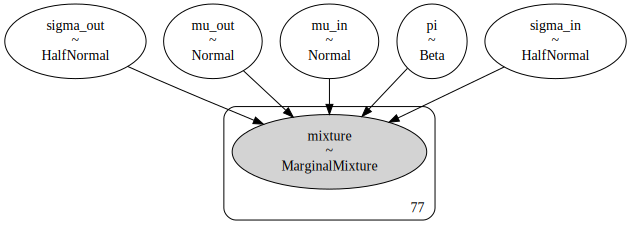

In [9]:
pm.model_to_graphviz(model)

In [10]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [11]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_in,-0.15,4.12,-9.54,8.27,0.07,0.51,2299.78,28.96,1.48
mu_out,2.93,8.14,-11.38,20.95,0.70,0.82,506.81,1935.67,1.46
pi,0.74,0.41,0.01,1.00,0.20,0.16,7.07,29.41,1.54
sigma_in,2.36,3.89,0.03,10.07,1.19,0.87,19.79,27.76,1.46
sigma_out,5.75,5.86,0.07,16.81,1.41,1.01,13.90,329.77,1.21


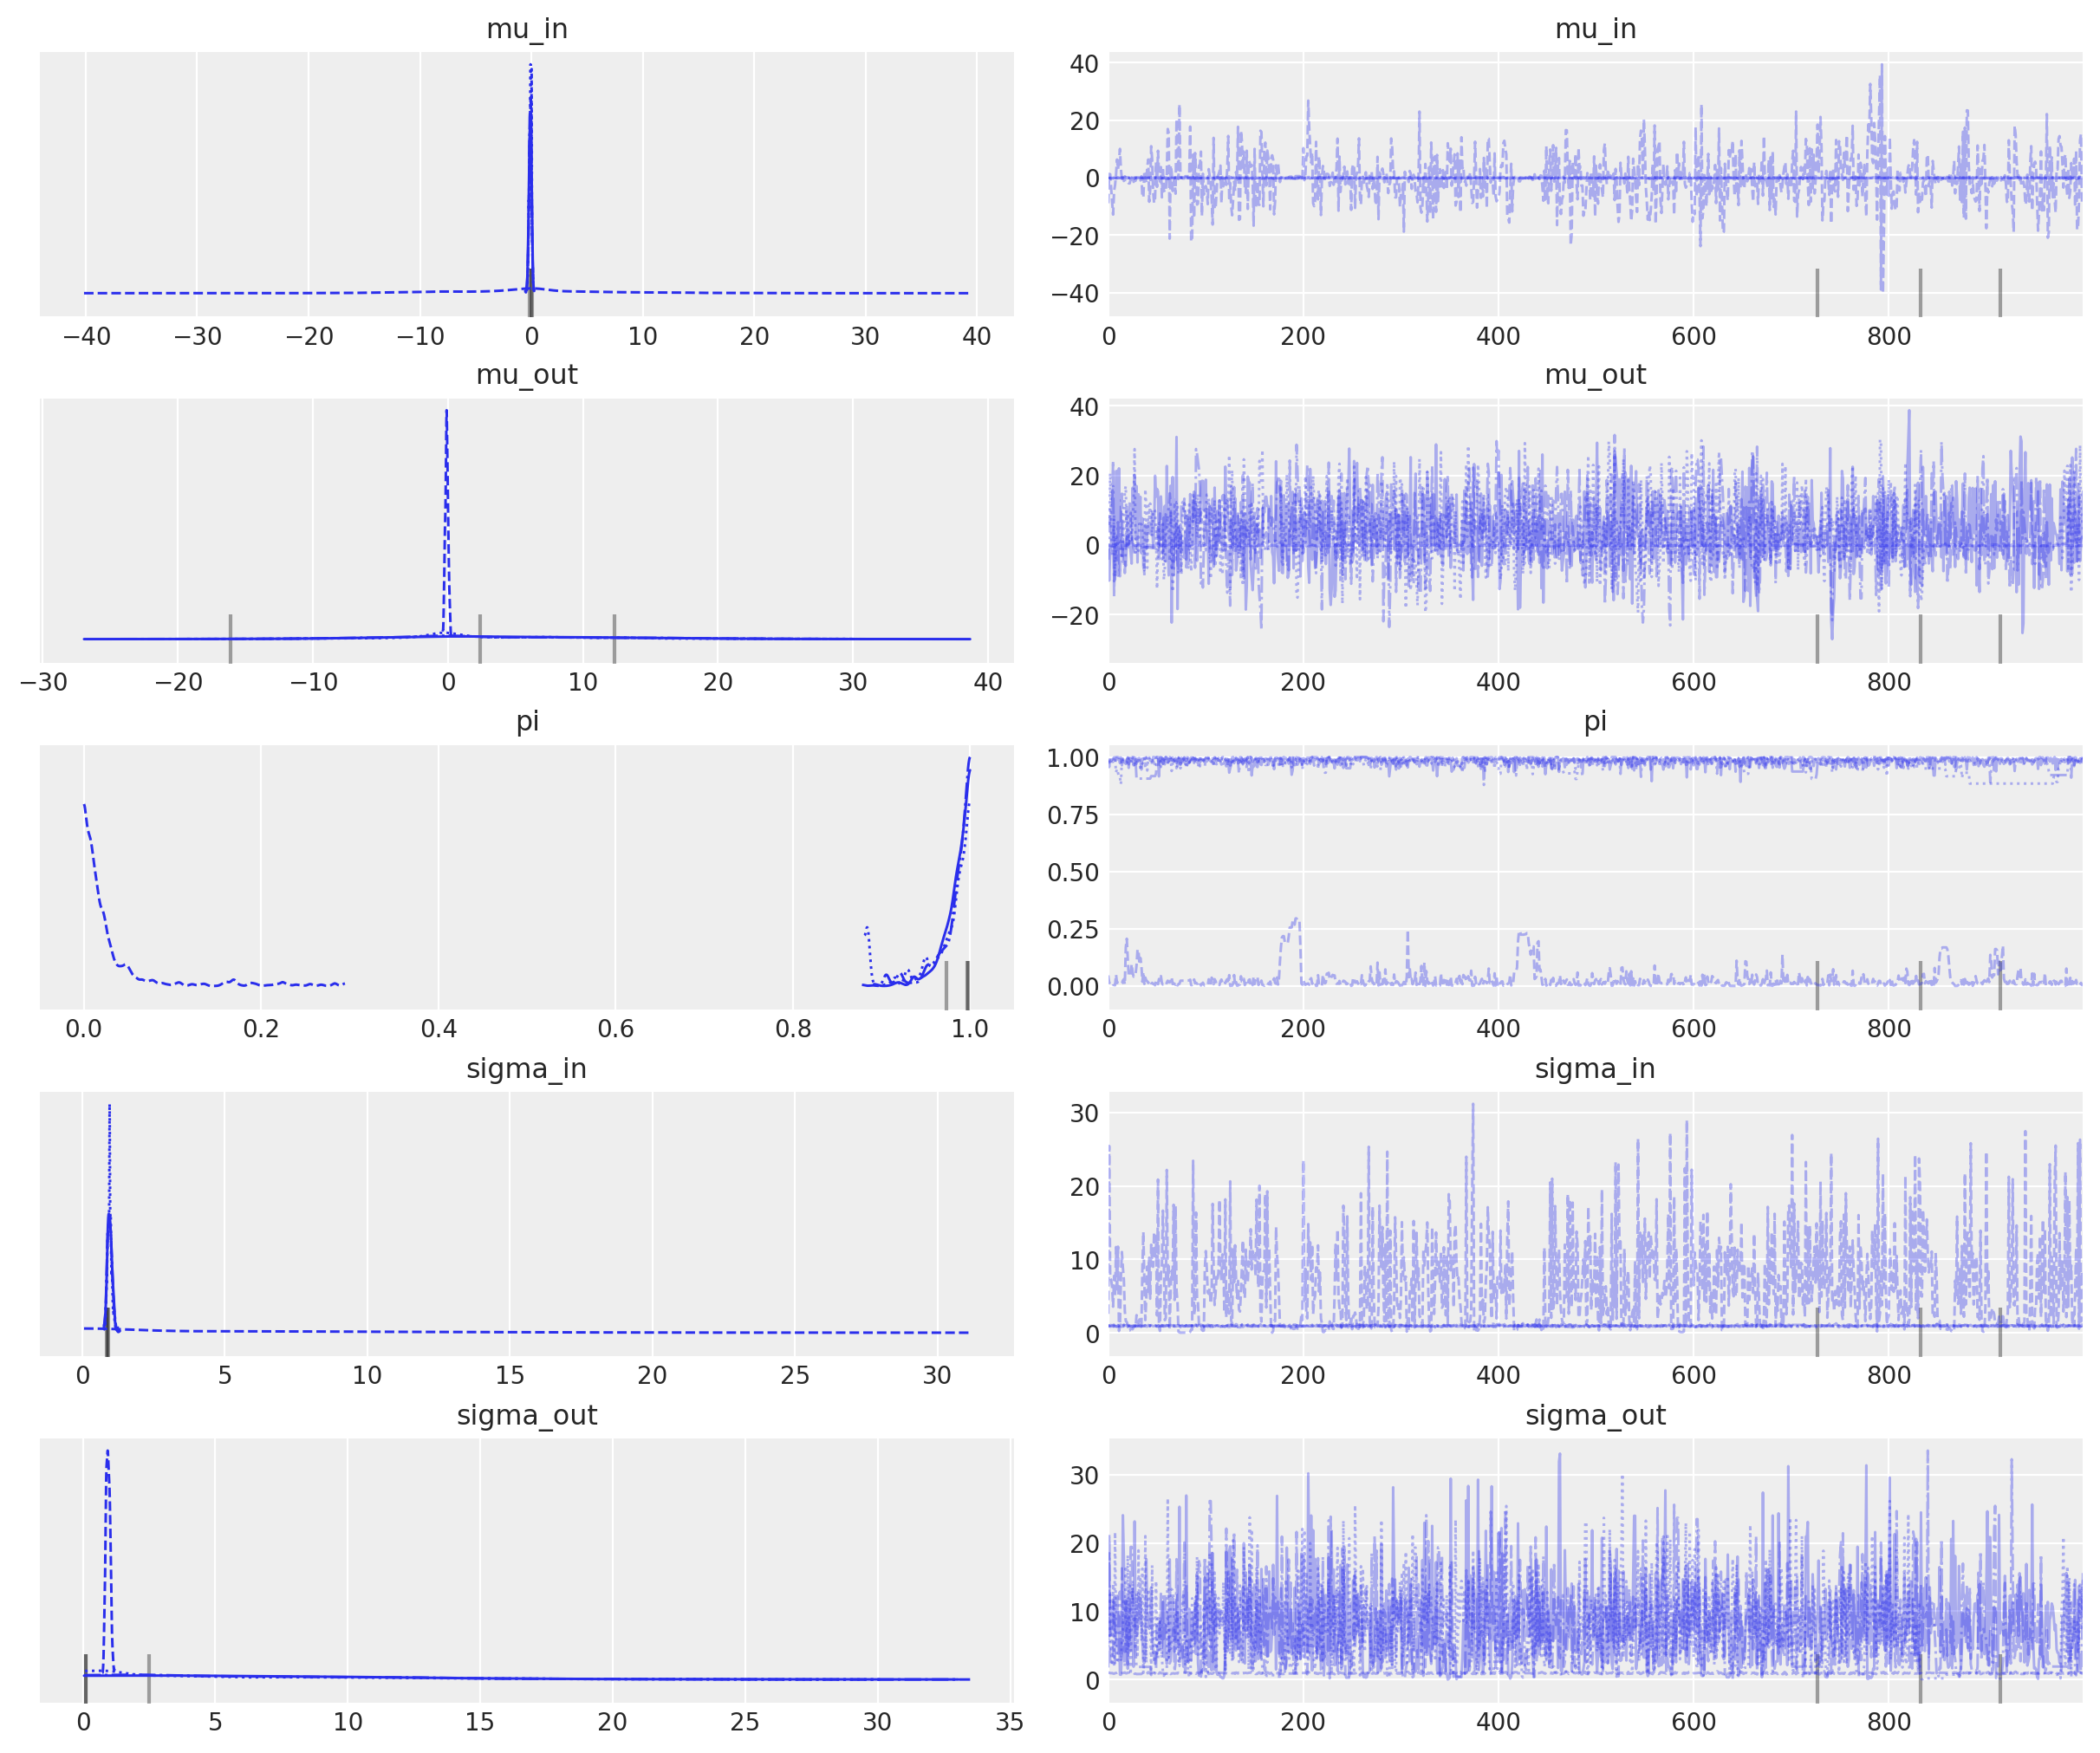

In [12]:
# Use ArviZ to plot posterior distributions of the parameters
az.plot_trace(trace)
plt.show()

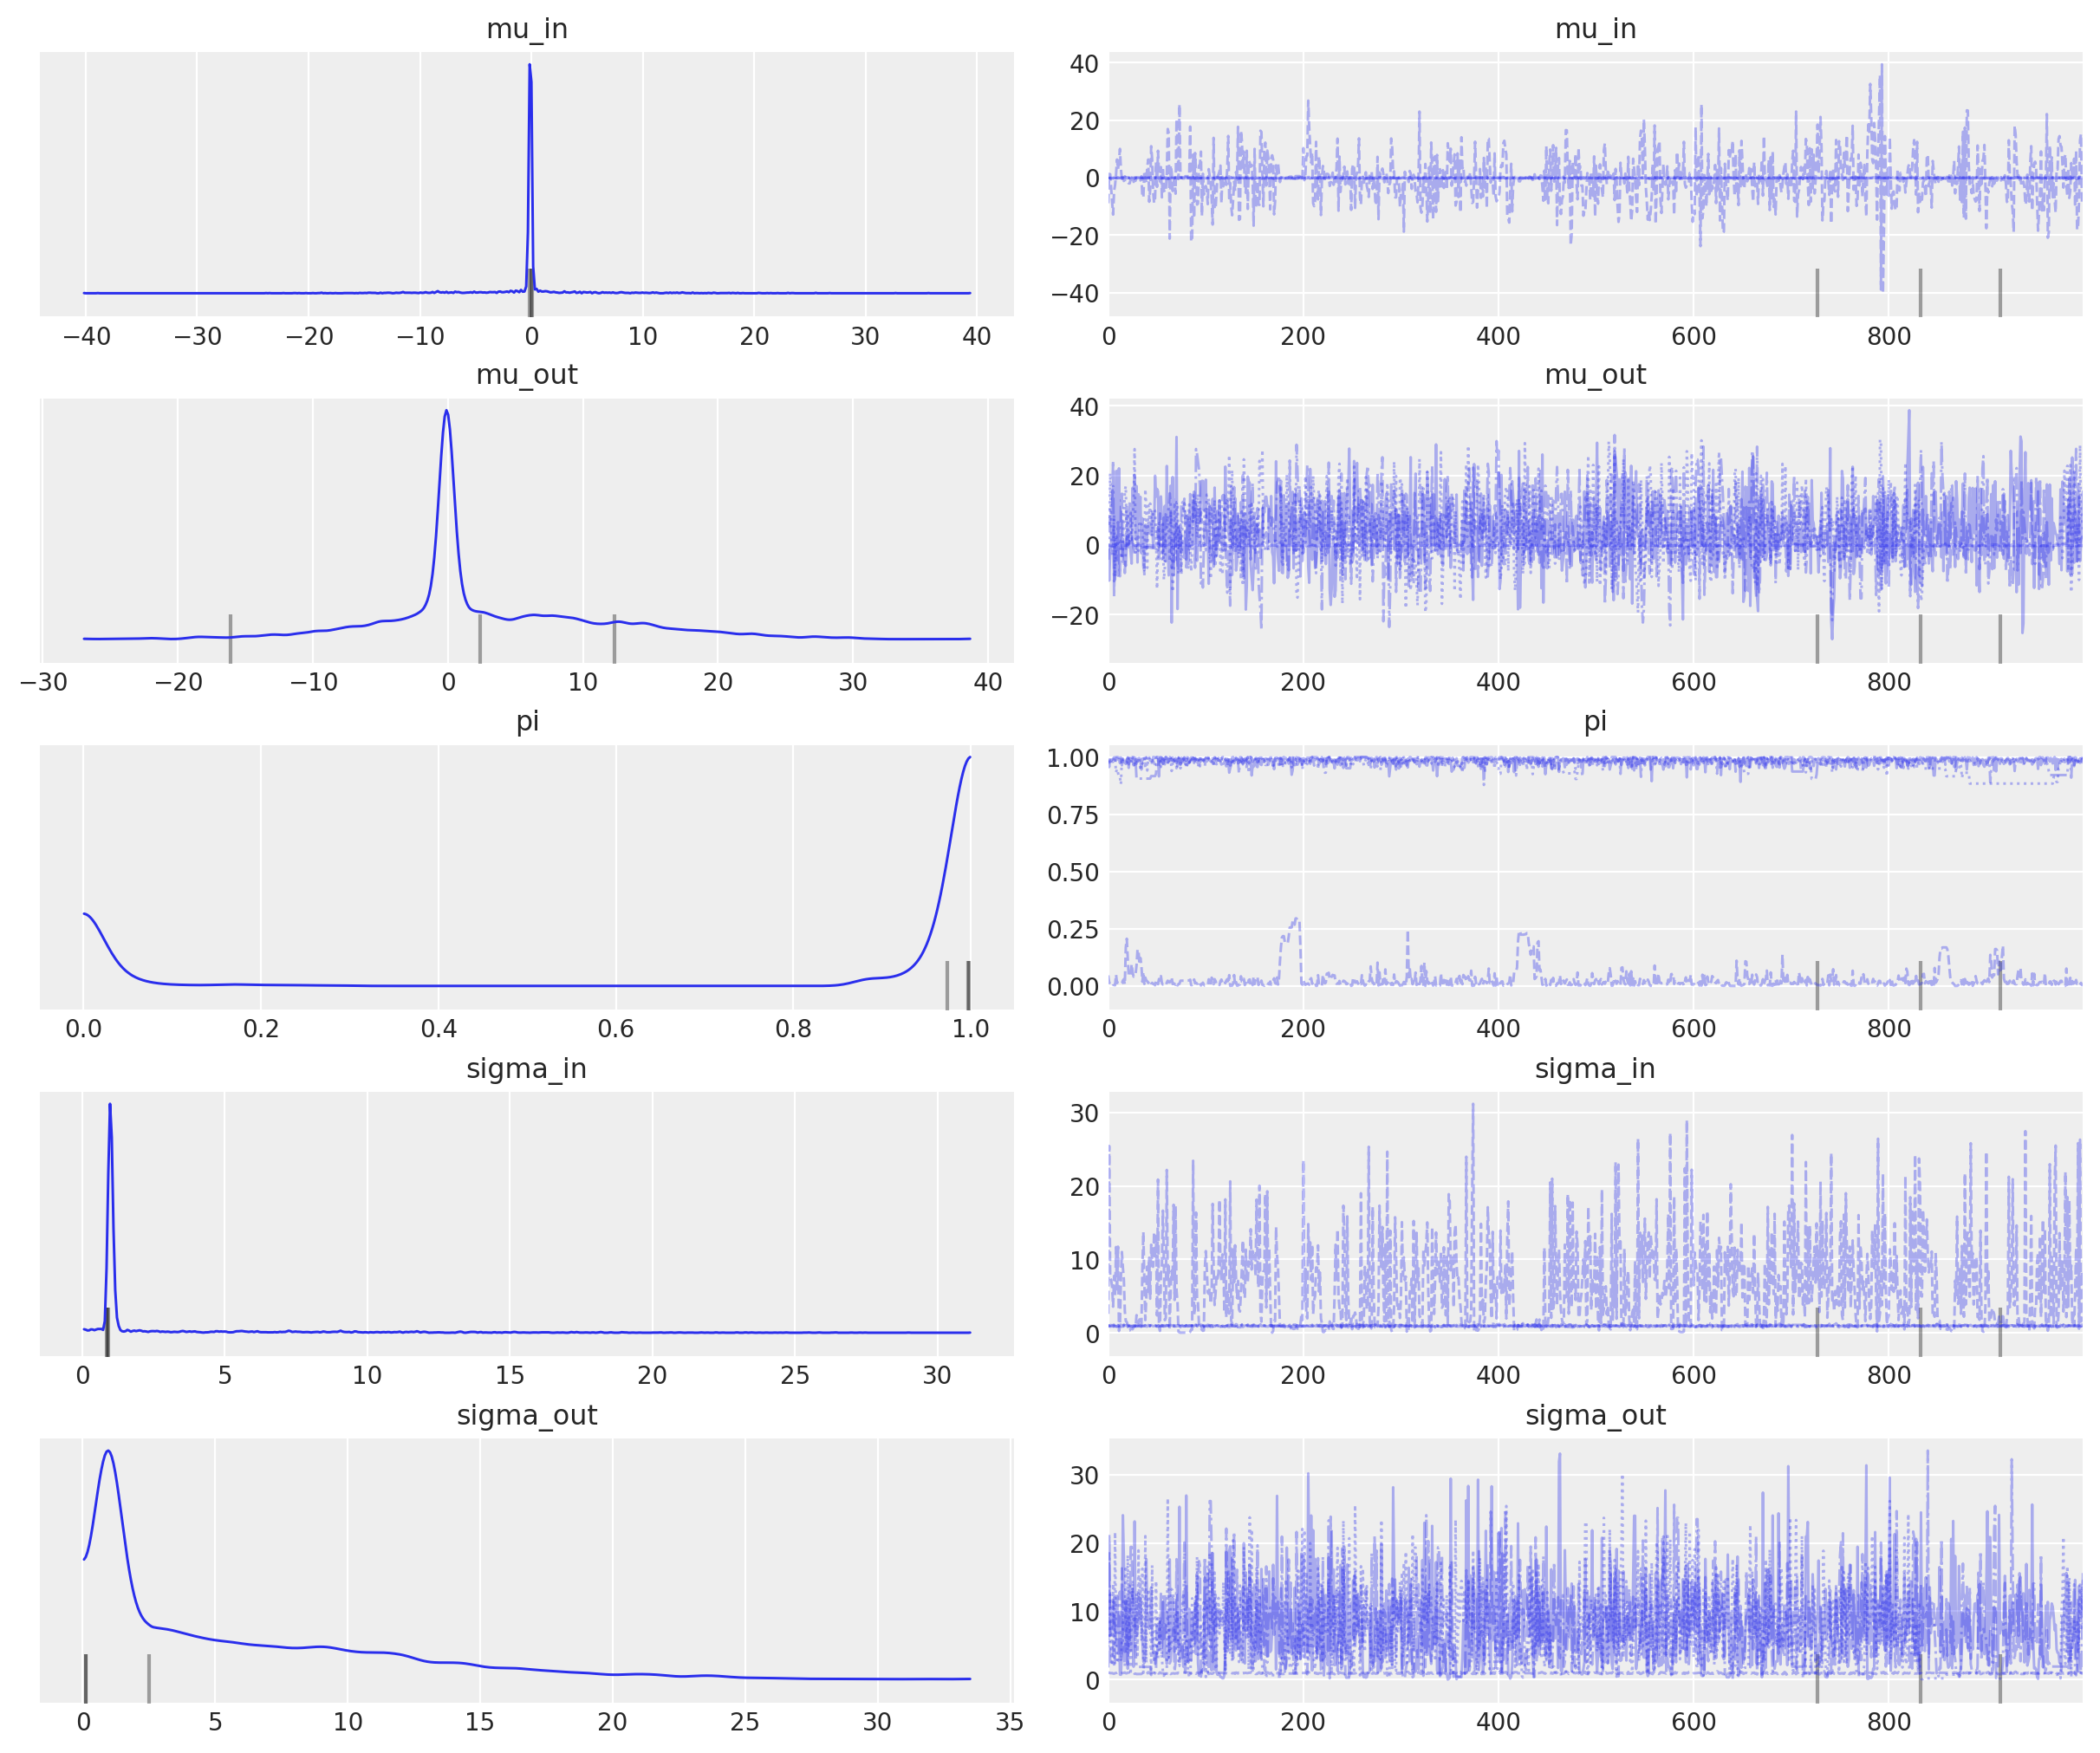

In [13]:
az.plot_trace(trace, combined=True);

In [14]:
# Test the model on the unseen (test) data using the learned parameters
with model:
    ppc_test = pm.sample_posterior_predictive(trace, var_names=["mu_in", "sigma_in", "mu_out", "sigma_out", "pi"])

# Get posterior means of the parameters from the trained model
posterior_summary = az.summary(trace)

Sampling: [mu_in, mu_out, pi, sigma_in, sigma_out]


Output()

In [15]:
mu_in_post = posterior_summary.loc['mu_in', 'mean']
sigma_in_post = posterior_summary.loc['sigma_in', 'mean']
mu_out_post = posterior_summary.loc['mu_out', 'mean']
sigma_out_post = posterior_summary.loc['sigma_out', 'mean']
pi_post = posterior_summary.loc['pi', 'mean']

In [27]:
# Classify test data points as inliers or outliers based on the learned posterior
# We use the posterior parameters for classification
inlier_prob_threshold = 0.5  # Threshold for classification based on the posterior mixture weight
inlier_prob = pi_post  # Posterior mean for inlier probability

In [28]:
# Create a mask for test data points that are classified as outliers
outlier_mask = (test_data > mu_out_post - 2 * sigma_out_post) | (test_data < mu_in_post - 2 * sigma_in_post)


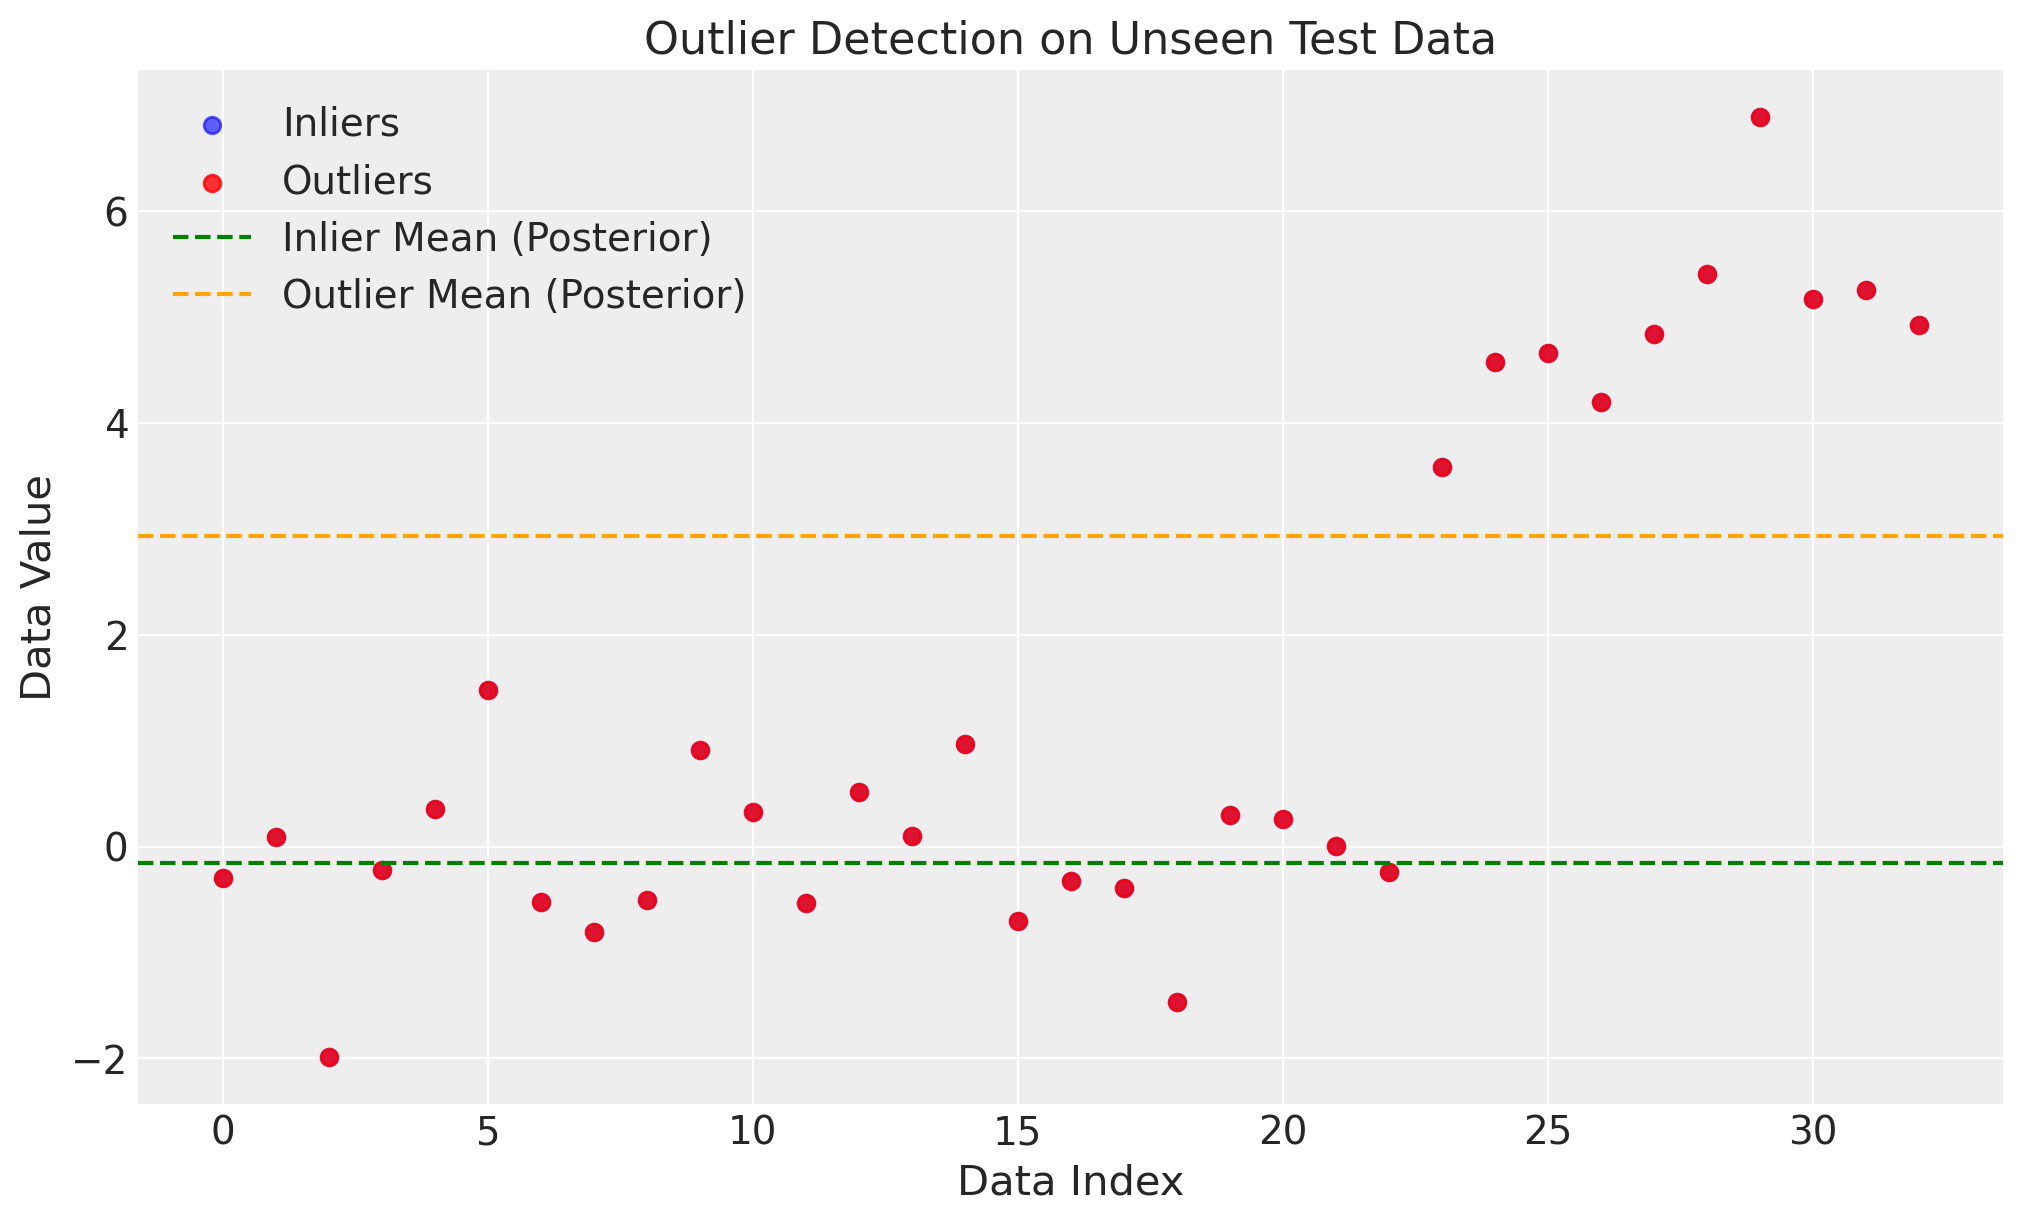

In [29]:
# Visualize the classification results on the test data
plt.figure(figsize=(10, 6))

# Plot all test data points in blue (assumed inliers)
plt.scatter(np.arange(len(test_data)), test_data, color='blue', label='Inliers', alpha=0.6)

# Highlight the points classified as outliers in red
plt.scatter(np.arange(len(test_data))[outlier_mask], test_data[outlier_mask], color='red', label='Outliers', alpha=0.8)

plt.axhline(y=mu_in_post, color='green', linestyle='--', label='Inlier Mean (Posterior)')
plt.axhline(y=mu_out_post, color='orange', linestyle='--', label='Outlier Mean (Posterior)')
plt.title('Outlier Detection on Unseen Test Data')
plt.xlabel('Data Index')
plt.ylabel('Data Value')
plt.legend()
plt.show()